In [17]:
import os
import torch

# Training
train_path = "data/sub_2CMEMS-MEDSEA-2010-2016-training.nc.bin"
test_path = "data/sub_2CMEMS-MEDSEA-2017-testing.nc.bin"
use_cuda = torch.cuda.is_available()
batch_size = 128
num_workers = 8

# Experiment

num_cnn_layers = 3
num_lstm_layers = 0
num_fc_layers = 4
hidden_size = 128

# defines the dimensions of the neighborhood
# a neghborhood of size 1 means that the axis is not considered.
# preferably, the neighborhood size should be odd
lat_neghborhood_size = 1
lon_neghborhood_size = 1
depth_neghborhood_size = 11

with_position_embedding = True

experiment_name = f"spatiotemporal_model_\
{num_cnn_layers}_\
{num_lstm_layers}_\
{num_fc_layers}_\
{hidden_size}_\
{lat_neghborhood_size}_\
{lon_neghborhood_size}_\
{depth_neghborhood_size}_\
{'with_position_embedding' if with_position_embedding else 'without_position_embedding'}"


if os.path.exists(f"checkpoints/{experiment_name}/"):
    print(f"Experiment {experiment_name} already exists, resuming training")
    ckpt = torch.load(f"checkpoints/{experiment_name}/last.ckpt")
else:
    print(f"Starting new experiment {experiment_name}")
    ckpt = None


Starting new experiment spatiotemporal_model_3_0_4_128_1_1_11_with_position_embedding


In [18]:
from datasets.memmap_dataset import MemMapSpatioTemporalDataset

valid_dataset = MemMapSpatioTemporalDataset(
    bin_path=train_path,
    train=True,
    valid=True,
    valid_interval_length=365,
    lat_neghborhood_size=lat_neghborhood_size,
    lon_neghborhood_size=lon_neghborhood_size,
    depth_neghborhood_size=depth_neghborhood_size,
    overwrite_index=False,
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

In [19]:
from models.spatiotemporal_model import SpatioTemporalModel
from models.lightning_base import LightningBase


model = SpatioTemporalModel(
    features_size=valid_dataset.nfeatures,
    hidden_size=hidden_size,
    targets_size=valid_dataset.ntargets,

    num_cnn_layers=num_cnn_layers,
    num_lstm_layers=num_lstm_layers,
    num_fc_layers=num_fc_layers,

    lat_neghborhood_size=lat_neghborhood_size,
    lon_neghborhood_size=lon_neghborhood_size,
    depth_neghborhood_size=depth_neghborhood_size,

    with_position_embedding=with_position_embedding,
    lat_size=valid_dataset.nlatitudes,
    lon_size=valid_dataset.nlongitudes,
    depth_size=valid_dataset.ndepths,
)

if ckpt is not None:
    lightning_model = LightningBase.load_from_checkpoint(
        model=model,
        checkpoint_path=ckpt
    ).to('cuda' if use_cuda else 'cpu')
else:
    print("No checkpoint found, using random weights.")
    lightning_model = LightningBase(
        model=model
    ).to('cuda' if use_cuda else 'cpu')

model = lightning_model.model

No checkpoint found, using random weights.


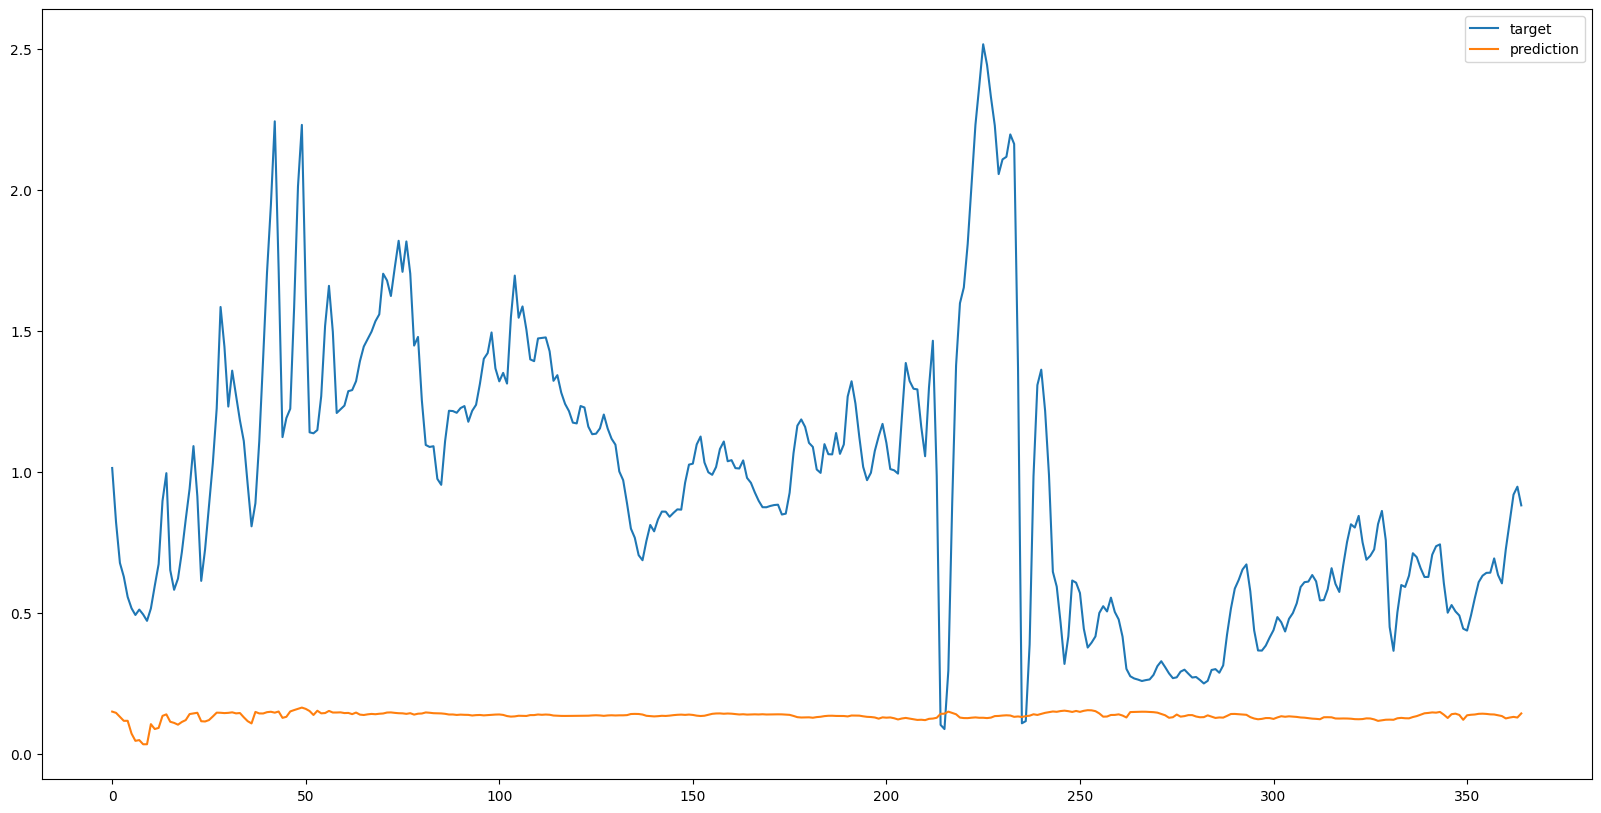

In [20]:
# plot the prediction vs the target
import matplotlib.pyplot as plt
import numpy as np

rand_idx = np.random.randint(0, len(valid_dataset))


valid_position, valid_features, valid_targets = valid_dataset[rand_idx]
valid_position = valid_position.unsqueeze(0).to('cuda' if use_cuda else 'cpu')
valid_features = valid_features.unsqueeze(0).to('cuda' if use_cuda else 'cpu')
valid_targets = valid_targets.unsqueeze(0).to('cuda' if use_cuda else 'cpu')

valid_prediction = model(valid_position, valid_features)

# plot the prediction vs the target

plt.figure(figsize=(20, 10))
plt.plot(valid_targets[0, :, 0].detach(), label="target")
plt.plot(valid_prediction[0, :, 0].detach(), label="prediction")
plt.legend()
plt.show()